# GameTheory-5-ZeroSum-Minimax

**Navigation** : [<< 4-NashEquilibrium](GameTheory-4-NashEquilibrium.ipynb) | [Index](README.md) | [6-EvolutionTrust >>](GameTheory-6-EvolutionTrust.ipynb)

## Jeux a Somme Nulle et Theoreme Minimax

Ce notebook explore les **jeux a somme nulle** et le celebre **theoreme minimax** de Von Neumann (1928).

### Objectifs

1. Definir les jeux a somme nulle
2. Comprendre les strategies maximin et minimax
3. Demontrer le theoreme minimax
4. Resoudre par programmation lineaire
5. Applications : Pierre-Feuille-Ciseaux, Blotto

### Duree estimee : 40 minutes

### Theoreme Minimax (Von Neumann, 1928)
> Dans tout jeu a deux joueurs et somme nulle, il existe une valeur $v$ telle que :
> $$\max_{\sigma} \min_{\tau} u(\sigma, \tau) = \min_{\tau} \max_{\sigma} u(\sigma, \tau) = v$$

In [1]:
# Imports
import numpy as np
import nashpy as nash
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

## 1. Definition : Jeux a somme nulle

### Definition

Un jeu est a **somme nulle** si pour tout profil de strategies $(s_1, s_2)$ :
$$u_1(s_1, s_2) + u_2(s_1, s_2) = 0$$

Equivalemment : $B = -A$ (les gains d'un joueur sont les pertes de l'autre).

### Exemples classiques
- Pierre-Feuille-Ciseaux
- Echecs, Dames, Go (victoire = +1, defaite = -1)
- Matching Pennies
- Colonel Blotto

In [2]:
class ZeroSumGame:
    """
    Jeu a somme nulle a deux joueurs.
    
    La matrice A represente les gains de Row.
    Les gains de Col sont -A.
    """
    
    def __init__(self, A: np.ndarray, 
                 row_labels: list = None,
                 col_labels: list = None,
                 name: str = "Zero-Sum Game"):
        self.A = np.array(A, dtype=float)
        self.m, self.n = self.A.shape
        self.name = name
        self.row_labels = row_labels or [f"R{i}" for i in range(self.m)]
        self.col_labels = col_labels or [f"C{j}" for j in range(self.n)]
    
    def payoff(self, sigma_row: np.ndarray, sigma_col: np.ndarray) -> float:
        """Gain de Row (= -gain de Col)."""
        return sigma_row @ self.A @ sigma_col
    
    def display(self):
        """Affiche la matrice des gains."""
        print(f"\n{self.name} (gains de Row)")
        print("=" * 50)
        
        # Header
        header = "        " + "  ".join(f"{c:>8}" for c in self.col_labels)
        print(header)
        print("-" * len(header))
        
        # Rows
        for i, label in enumerate(self.row_labels):
            row_str = f"{label:>6}  "
            row_str += "  ".join(f"{self.A[i,j]:>8.2f}" for j in range(self.n))
            print(row_str)

# Exemples de jeux a somme nulle

# Pierre-Feuille-Ciseaux
rps = ZeroSumGame(
    A=[[0, -1, 1],
       [1, 0, -1],
       [-1, 1, 0]],
    row_labels=['Pierre', 'Feuille', 'Ciseaux'],
    col_labels=['Pierre', 'Feuille', 'Ciseaux'],
    name="Pierre-Feuille-Ciseaux"
)
rps.display()

# Matching Pennies
mp = ZeroSumGame(
    A=[[1, -1],
       [-1, 1]],
    row_labels=['Pile', 'Face'],
    col_labels=['Pile', 'Face'],
    name="Matching Pennies"
)
mp.display()


Pierre-Feuille-Ciseaux (gains de Row)
          Pierre   Feuille   Ciseaux
------------------------------------
Pierre      0.00     -1.00      1.00
Feuille      1.00      0.00     -1.00
Ciseaux     -1.00      1.00      0.00

Matching Pennies (gains de Row)
            Pile      Face
--------------------------
  Pile      1.00     -1.00
  Face     -1.00      1.00


## 2. Strategies Maximin et Minimax

### Strategie Maximin (pour Row)

Row cherche a **maximiser** son gain minimum (pessimiste) :
$$\bar{v}_1 = \max_{\sigma} \min_{\tau} \sigma^T A \tau = \max_{\sigma} \min_j (A\sigma)_j$$

### Strategie Minimax (pour Col)

Col cherche a **minimiser** le gain maximum de Row :
$$\underline{v}_2 = \min_{\tau} \max_{\sigma} \sigma^T A \tau = \min_{\tau} \max_i (A^T\tau)_i$$

### Inegalite fondamentale

Toujours : $\bar{v}_1 \leq \underline{v}_2$ (le pessimiste fait au moins aussi mal que l'optimiste).

In [3]:
def maximin_pure(game: ZeroSumGame) -> Tuple[int, float]:
    """
    Calcule la strategie maximin pure de Row.
    
    Returns:
        (action, valeur maximin)
    """
    min_per_row = np.min(game.A, axis=1)  # Pire cas pour chaque action
    best_row = np.argmax(min_per_row)     # Meilleur pire cas
    return best_row, min_per_row[best_row]

def minimax_pure(game: ZeroSumGame) -> Tuple[int, float]:
    """
    Calcule la strategie minimax pure de Col.
    
    Returns:
        (action, valeur minimax)
    """
    max_per_col = np.max(game.A, axis=0)  # Pire cas pour Col (meilleur pour Row)
    best_col = np.argmin(max_per_col)     # Minimise le max de Row
    return best_col, max_per_col[best_col]

def analyze_maximin_minimax(game: ZeroSumGame):
    """Analyse les strategies maximin/minimax."""
    game.display()
    
    row_action, v_maximin = maximin_pure(game)
    col_action, v_minimax = minimax_pure(game)
    
    print(f"\nAnalyse maximin/minimax:")
    print("-" * 40)
    print(f"Maximin (Row): action '{game.row_labels[row_action]}', valeur = {v_maximin}")
    print(f"Minimax (Col): action '{game.col_labels[col_action]}', valeur = {v_minimax}")
    
    if abs(v_maximin - v_minimax) < 1e-10:
        print(f"\n=> Point-selle existe ! Valeur du jeu = {v_maximin}")
        print(f"   Equilibre: ({game.row_labels[row_action]}, {game.col_labels[col_action]})")
    else:
        print(f"\n=> Pas de point-selle en strategies pures")
        print(f"   Gap: {v_minimax - v_maximin}")

# Analyser les jeux
analyze_maximin_minimax(mp)
print("\n" + "="*60 + "\n")
analyze_maximin_minimax(rps)


Matching Pennies (gains de Row)
            Pile      Face
--------------------------
  Pile      1.00     -1.00
  Face     -1.00      1.00

Analyse maximin/minimax:
----------------------------------------
Maximin (Row): action 'Pile', valeur = -1.0
Minimax (Col): action 'Pile', valeur = 1.0

=> Pas de point-selle en strategies pures
   Gap: 2.0



Pierre-Feuille-Ciseaux (gains de Row)
          Pierre   Feuille   Ciseaux
------------------------------------
Pierre      0.00     -1.00      1.00
Feuille      1.00      0.00     -1.00
Ciseaux     -1.00      1.00      0.00

Analyse maximin/minimax:
----------------------------------------
Maximin (Row): action 'Pierre', valeur = -1.0
Minimax (Col): action 'Pierre', valeur = 1.0

=> Pas de point-selle en strategies pures
   Gap: 2.0


### Interpretation : Absence de point-selle

L'analyse des deux jeux revele l'absence de point-selle en strategies pures :

| Jeu | Maximin (Row) | Minimax (Col) | Gap |
|-----|---------------|---------------|-----|
| Matching Pennies | -1 | +1 | 2 |
| Pierre-Feuille-Ciseaux | -1 | +1 | 2 |

**Pourquoi ce gap ?**
- **Maximin = -1** : En strategie pure, Row peut toujours perdre (si Col devine son choix)
- **Minimax = +1** : En strategie pure, Row peut toujours gagner (si Col se trompe)

**Consequence** : Ces jeux n'ont pas de strategie dominante. Si Row jouait toujours "Pierre", Col jouerait toujours "Feuille" et gagnerait systematiquement.

> **Point cle** : Le gap (minimax - maximin > 0) indique qu'il faut passer aux **strategies mixtes** (probabilistes) pour trouver un equilibre. C'est exactement ce que le theoreme minimax de Von Neumann garantit.

In [4]:
# Jeu avec point-selle
saddle_game = ZeroSumGame(
    A=[[3, 2, 4],
       [1, 4, 3],
       [2, 3, 2]],
    row_labels=['R1', 'R2', 'R3'],
    col_labels=['C1', 'C2', 'C3'],
    name="Jeu avec point-selle"
)

analyze_maximin_minimax(saddle_game)


Jeu avec point-selle (gains de Row)
              C1        C2        C3
------------------------------------
    R1      3.00      2.00      4.00
    R2      1.00      4.00      3.00
    R3      2.00      3.00      2.00

Analyse maximin/minimax:
----------------------------------------
Maximin (Row): action 'R1', valeur = 2.0
Minimax (Col): action 'C1', valeur = 3.0

=> Pas de point-selle en strategies pures
   Gap: 1.0


## 3. Theoreme Minimax de Von Neumann

### Enonce

Pour tout jeu matriciel a somme nulle, en **strategies mixtes** :

$$\max_{\sigma \in \Delta_m} \min_{\tau \in \Delta_n} \sigma^T A \tau = \min_{\tau \in \Delta_n} \max_{\sigma \in \Delta_m} \sigma^T A \tau = v$$

ou $\Delta_k$ est le simplexe des probabilites en dimension $k$.

### Consequences

1. La **valeur du jeu** $v$ est bien definie
2. Il existe des strategies **optimales** $\sigma^*$ et $\tau^*$
3. Ces strategies forment un **equilibre de Nash**

In [5]:
def solve_minimax_lp(game: ZeroSumGame) -> Tuple[np.ndarray, float]:
    """
    Resout le probleme minimax par programmation lineaire.
    
    Probleme primal (Row maximise):
        max v
        s.t. A @ sigma >= v * 1
             sigma >= 0, sum(sigma) = 1
    
    Reformule comme:
        min -v
        s.t. -A.T @ sigma + v * 1 <= 0
             sum(sigma) = 1
             sigma >= 0
    
    Returns:
        (strategie optimale de Row, valeur du jeu)
    """
    m, n = game.A.shape
    
    # Variables: [sigma_0, ..., sigma_{m-1}, v]
    # Objectif: max v <=> min -v
    c = np.zeros(m + 1)
    c[-1] = -1  # min -v
    
    # Contraintes d'inegalite: A.T @ sigma >= v * 1
    # Reformule: -A.T @ sigma + v <= 0
    A_ub = np.zeros((n, m + 1))
    A_ub[:, :m] = -game.A.T
    A_ub[:, m] = 1
    b_ub = np.zeros(n)
    
    # Contrainte d'egalite: sum(sigma) = 1
    A_eq = np.zeros((1, m + 1))
    A_eq[0, :m] = 1
    b_eq = np.array([1])
    
    # Bornes: sigma >= 0, v non borne
    bounds = [(0, None) for _ in range(m)] + [(None, None)]
    
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
    
    if result.success:
        sigma = result.x[:m]
        v = result.x[m]
        return sigma, v
    else:
        raise ValueError(f"LP failed: {result.message}")

def solve_minimax_dual(game: ZeroSumGame) -> Tuple[np.ndarray, float]:
    """
    Resout le probleme dual (Col minimise).
    
    Returns:
        (strategie optimale de Col, valeur du jeu)
    """
    # Le dual pour Col sur -A.T est equivalent au primal pour Row sur A.T
    m, n = game.A.shape
    
    # Variables: [tau_0, ..., tau_{n-1}, w]
    # Objectif: min w
    c = np.zeros(n + 1)
    c[-1] = 1  # min w
    
    # Contraintes: A @ tau <= w * 1
    A_ub = np.zeros((m, n + 1))
    A_ub[:, :n] = game.A
    A_ub[:, n] = -1
    b_ub = np.zeros(m)
    
    # Contrainte d'egalite: sum(tau) = 1
    A_eq = np.zeros((1, n + 1))
    A_eq[0, :n] = 1
    b_eq = np.array([1])
    
    # Bornes
    bounds = [(0, None) for _ in range(n)] + [(None, None)]
    
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
    
    if result.success:
        tau = result.x[:n]
        w = result.x[n]
        return tau, w
    else:
        raise ValueError(f"LP failed: {result.message}")

# Resoudre Matching Pennies
print("Resolution de Matching Pennies")
print("=" * 50)
mp.display()

sigma, v_primal = solve_minimax_lp(mp)
tau, v_dual = solve_minimax_dual(mp)

print(f"\nSolution:")
print(f"  Strategie Row: {np.round(sigma, 4)}")
print(f"  Valeur (primal): {v_primal:.4f}")
print(f"  Strategie Col: {np.round(tau, 4)}")
print(f"  Valeur (dual): {v_dual:.4f}")
print(f"\nVerification theoreme minimax: primal = dual ? {abs(v_primal - v_dual) < 1e-6}")

Resolution de Matching Pennies

Matching Pennies (gains de Row)
            Pile      Face
--------------------------
  Pile      1.00     -1.00
  Face     -1.00      1.00

Solution:
  Strategie Row: [0.5 0.5]
  Valeur (primal): -0.0000
  Strategie Col: [0.5 0.5]
  Valeur (dual): -0.0000

Verification theoreme minimax: primal = dual ? True


### Interpretation : Resolution par programmation lineaire

La resolution de Matching Pennies par LP confirme le theoreme minimax :

**Resultats** :
| Element | Valeur | Signification |
|---------|--------|---------------|
| Strategie Row | `[0.5, 0.5]` | Jouer Pile et Face avec probabilite egale |
| Strategie Col | `[0.5, 0.5]` | Meme strategie optimale (jeu symetrique) |
| Valeur du jeu | 0 | Ni avantage ni desavantage pour Row |
| Primal = Dual | Oui | Verification du theoreme de dualite forte |

**Pourquoi 50/50 ?** Si Row jouait Pile plus souvent, Col pourrait exploiter ce biais en jouant Face systematiquement. L'equilibre est atteint quand aucun joueur ne peut ameliorer sa situation en changeant sa strategie.

> **Note technique** : La formulation LP transforme le probleme "max-min" en un probleme d'optimisation standard, resoluble en temps polynomial par l'algorithme du simplexe.

In [6]:
# Resoudre Pierre-Feuille-Ciseaux
print("Resolution de Pierre-Feuille-Ciseaux")
print("=" * 50)
rps.display()

sigma, v_primal = solve_minimax_lp(rps)
tau, v_dual = solve_minimax_dual(rps)

print(f"\nSolution:")
print(f"  Strategie Row: {np.round(sigma, 4)}")
print(f"  Valeur du jeu: {v_primal:.4f}")
print(f"  Strategie Col: {np.round(tau, 4)}")

# Verification par Nashpy
rps_nash = nash.Game(rps.A, -rps.A)
for eq in rps_nash.support_enumeration():
    print(f"\nVerification Nashpy: {np.round(eq[0], 4)}, {np.round(eq[1], 4)}")

Resolution de Pierre-Feuille-Ciseaux

Pierre-Feuille-Ciseaux (gains de Row)
          Pierre   Feuille   Ciseaux
------------------------------------
Pierre      0.00     -1.00      1.00
Feuille      1.00      0.00     -1.00
Ciseaux     -1.00      1.00      0.00

Solution:
  Strategie Row: [0.3333 0.3333 0.3333]
  Valeur du jeu: -0.0000
  Strategie Col: [0.3333 0.3333 0.3333]

Verification Nashpy: [0.3333 0.3333 0.3333], [0.3333 0.3333 0.3333]


## 4. Visualisation du theoreme minimax

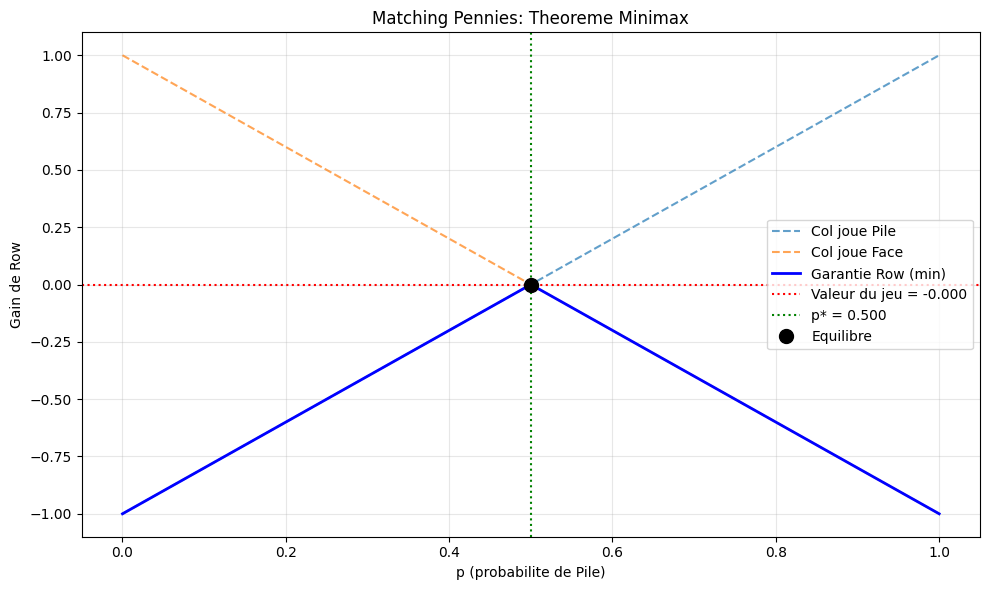

In [7]:
def visualize_minimax_2x2(game: ZeroSumGame):
    """
    Visualise le theoreme minimax pour un jeu 2x2.
    
    Montre:
    - Gain de Row en fonction de p (proba de R0) pour differents q (proba de C0)
    - L'enveloppe inferieure (maximin)
    - Le point d'equilibre
    """
    if game.A.shape != (2, 2):
        raise ValueError("Cette visualisation est pour les jeux 2x2")
    
    p_vals = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Gain de Row pour differentes strategies pures de Col
    for j in range(2):
        gains = []
        for p in p_vals:
            sigma = np.array([p, 1-p])
            tau = np.zeros(2)
            tau[j] = 1
            gains.append(game.payoff(sigma, tau))
        ax.plot(p_vals, gains, '--', label=f'Col joue {game.col_labels[j]}', alpha=0.7)
    
    # Enveloppe inferieure (min sur les strategies de Col)
    min_gains = []
    for p in p_vals:
        sigma = np.array([p, 1-p])
        min_g = min(game.payoff(sigma, np.array([1, 0])), 
                    game.payoff(sigma, np.array([0, 1])))
        min_gains.append(min_g)
    ax.plot(p_vals, min_gains, 'b-', linewidth=2, label='Garantie Row (min)')
    
    # Trouver l'equilibre
    sigma_opt, v = solve_minimax_lp(game)
    p_opt = sigma_opt[0]
    
    ax.axhline(y=v, color='r', linestyle=':', label=f'Valeur du jeu = {v:.3f}')
    ax.axvline(x=p_opt, color='g', linestyle=':', label=f'p* = {p_opt:.3f}')
    ax.plot(p_opt, v, 'ko', markersize=10, label='Equilibre')
    
    ax.set_xlabel(f'p (probabilite de {game.row_labels[0]})')
    ax.set_ylabel('Gain de Row')
    ax.set_title(f'{game.name}: Theoreme Minimax')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualiser Matching Pennies
visualize_minimax_2x2(mp)

### Interpretation : Visualisation du theoreme minimax

Le graphique illustre le coeur du theoreme minimax pour Matching Pennies :

**Lecture du graphique** :
- **Axe X** : probabilite $p$ que Row joue "Pile"
- **Lignes pointillees** : gain de Row si Col joue une strategie pure
- **Ligne bleue** : garantie minimale de Row (enveloppe inferieure)

**Point d'equilibre** :
- A $p^* = 0.5$, les deux lignes pointillees se croisent
- C'est le point ou Row **maximise sa garantie minimale**
- La valeur du jeu $v = 0$ : le jeu est equitable

> **Intuition geometrique** : Row cherche le point le plus haut sur l'enveloppe inferieure. Ce point correspond exactement a l'intersection des droites - la ou Col est indifferent entre ses deux actions.

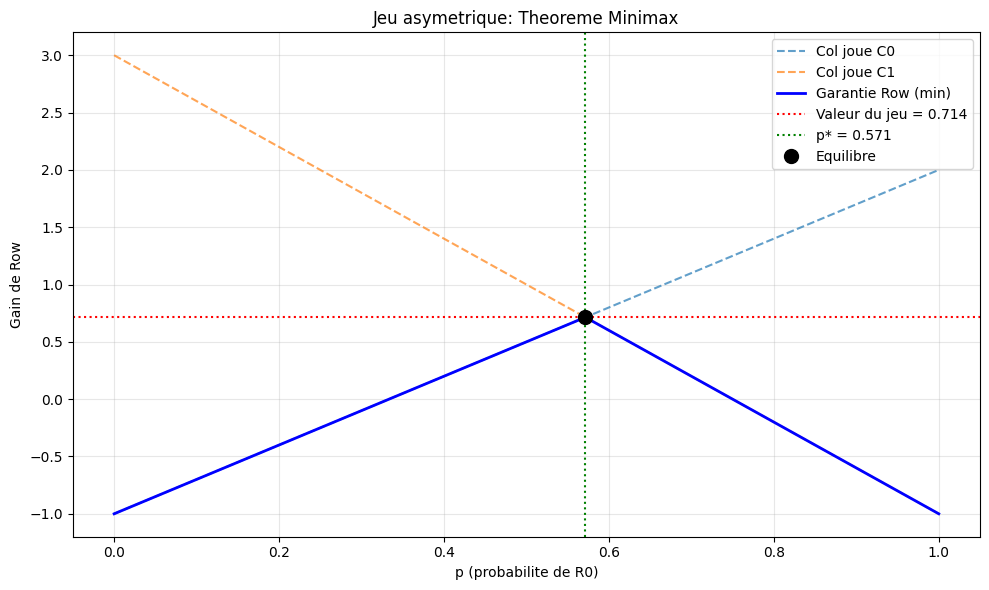

In [8]:
# Jeu asymetrique
asym_game = ZeroSumGame(
    A=[[2, -1],
       [-1, 3]],
    row_labels=['R0', 'R1'],
    col_labels=['C0', 'C1'],
    name="Jeu asymetrique"
)

visualize_minimax_2x2(asym_game)

## 5. Dualite en programmation lineaire

Le theoreme minimax est intimement lie a la **dualite LP**.

### Probleme primal (Row maximise)

$$\begin{aligned}
\max & \quad v \\
\text{s.t.} & \quad \sum_i \sigma_i A_{ij} \geq v \quad \forall j \\
& \quad \sum_i \sigma_i = 1 \\
& \quad \sigma_i \geq 0
\end{aligned}$$

### Probleme dual (Col minimise)

$$\begin{aligned}
\min & \quad w \\
\text{s.t.} & \quad \sum_j A_{ij} \tau_j \leq w \quad \forall i \\
& \quad \sum_j \tau_j = 1 \\
& \quad \tau_j \geq 0
\end{aligned}$$

Par dualite forte : $v^* = w^*$.

In [9]:
def verify_duality(game: ZeroSumGame):
    """Verifie la dualite LP pour le theoreme minimax."""
    print(f"\nVerification de la dualite pour: {game.name}")
    print("=" * 50)
    
    sigma_opt, v_primal = solve_minimax_lp(game)
    tau_opt, v_dual = solve_minimax_dual(game)
    
    print(f"\nProbleme primal (Row maximise):")
    print(f"  sigma* = {np.round(sigma_opt, 4)}")
    print(f"  v* = {v_primal:.6f}")
    
    print(f"\nProbleme dual (Col minimise):")
    print(f"  tau* = {np.round(tau_opt, 4)}")
    print(f"  w* = {v_dual:.6f}")
    
    print(f"\nDualite forte: v* = w* ? {abs(v_primal - v_dual) < 1e-6}")
    
    # Verification complementary slackness
    print(f"\nVerification des contraintes:")
    print(f"  Gains de Row pour chaque action Col:")
    gains_row = sigma_opt @ game.A
    for j, g in enumerate(gains_row):
        print(f"    Col joue {game.col_labels[j]}: {g:.4f} >= {v_primal:.4f} ? {g >= v_primal - 1e-6}")

verify_duality(rps)
verify_duality(mp)


Verification de la dualite pour: Pierre-Feuille-Ciseaux

Probleme primal (Row maximise):
  sigma* = [0.3333 0.3333 0.3333]
  v* = -0.000000

Probleme dual (Col minimise):
  tau* = [0.3333 0.3333 0.3333]
  w* = -0.000000

Dualite forte: v* = w* ? True

Verification des contraintes:
  Gains de Row pour chaque action Col:
    Col joue Pierre: 0.0000 >= -0.0000 ? True
    Col joue Feuille: 0.0000 >= -0.0000 ? True
    Col joue Ciseaux: -0.0000 >= -0.0000 ? True

Verification de la dualite pour: Matching Pennies

Probleme primal (Row maximise):
  sigma* = [0.5 0.5]
  v* = -0.000000

Probleme dual (Col minimise):
  tau* = [0.5 0.5]
  w* = -0.000000

Dualite forte: v* = w* ? True

Verification des contraintes:
  Gains de Row pour chaque action Col:
    Col joue Pile: 0.0000 >= -0.0000 ? True
    Col joue Face: 0.0000 >= -0.0000 ? True


## 6. Application : Colonel Blotto

Le jeu du **Colonel Blotto** est un jeu classique d'allocation de ressources.

### Regles
- Deux joueurs ont chacun $N$ soldats
- Ils les repartissent sur $K$ champs de bataille
- Celui qui a le plus de soldats sur un champ le gagne
- Objectif : gagner le plus de champs

In [10]:
from itertools import combinations_with_replacement

def generate_blotto_strategies(soldiers: int, battlefields: int) -> list:
    """
    Genere toutes les allocations possibles de soldats sur les champs.
    
    Returns:
        Liste de tuples (allocation) ou sum(allocation) = soldiers
    """
    strategies = []
    
    def generate(remaining, fields_left, current):
        if fields_left == 1:
            strategies.append(tuple(current + [remaining]))
            return
        
        for s in range(remaining + 1):
            generate(remaining - s, fields_left - 1, current + [s])
    
    generate(soldiers, battlefields, [])
    return strategies

def blotto_payoff(alloc1: tuple, alloc2: tuple) -> int:
    """
    Calcule le gain du joueur 1 (nombre de champs gagnes - nombre perdu).
    """
    wins = sum(1 if a > b else 0 for a, b in zip(alloc1, alloc2))
    losses = sum(1 if a < b else 0 for a, b in zip(alloc1, alloc2))
    return wins - losses

def create_blotto_game(soldiers: int, battlefields: int) -> ZeroSumGame:
    """
    Cree la matrice du jeu Colonel Blotto.
    """
    strategies = generate_blotto_strategies(soldiers, battlefields)
    n = len(strategies)
    
    A = np.zeros((n, n))
    for i, s1 in enumerate(strategies):
        for j, s2 in enumerate(strategies):
            A[i, j] = blotto_payoff(s1, s2)
    
    labels = [str(s) for s in strategies]
    return ZeroSumGame(A, labels, labels, f"Blotto({soldiers},{battlefields})")

# Petit exemple: 4 soldats, 3 champs
blotto_4_3 = create_blotto_game(4, 3)
print(f"Blotto(4 soldats, 3 champs)")
print(f"Nombre de strategies: {blotto_4_3.m}")

# Resoudre
sigma_opt, v = solve_minimax_lp(blotto_4_3)

print(f"\nValeur du jeu: {v:.4f}")
print(f"\nStrategies jouees avec probabilite > 0.01:")
for i, p in enumerate(sigma_opt):
    if p > 0.01:
        print(f"  {blotto_4_3.row_labels[i]}: {p:.3f}")

Blotto(4 soldats, 3 champs)
Nombre de strategies: 15

Valeur du jeu: -0.0000

Strategies jouees avec probabilite > 0.01:
  (0, 2, 2): 0.333
  (2, 0, 2): 0.333
  (2, 2, 0): 0.333


### Interpretation : Strategie optimale du Colonel Blotto

Les resultats revelent une propriete remarquable du jeu Blotto :

**Observation cle** : Sur les 15 strategies possibles, seules **3** sont jouees a l'equilibre, chacune avec probabilite 1/3 :
- `(0, 2, 2)` : abandonner un champ pour concentrer les forces
- `(2, 0, 2)` : meme logique, champ central abandonne
- `(2, 2, 0)` : meme logique, dernier champ abandonne

**Principe strategique** : La strategie `(2, 2, 0)` et ses permutations dominent car :
1. Elles garantissent de **gagner 2 champs sur 3** contre les repartitions uniformes comme `(1, 1, 2)`
2. Elles se **neutralisent mutuellement** (egalite contre elles-memes)

**Valeur du jeu = 0** : Le jeu est parfaitement equilibre - aucun joueur ne peut garantir un avantage.

> **Intuition militaire** : Il vaut mieux abandonner completement un front pour dominer les autres, plutot que de diluer ses forces uniformement. C'est le principe de la **concentration des forces**.

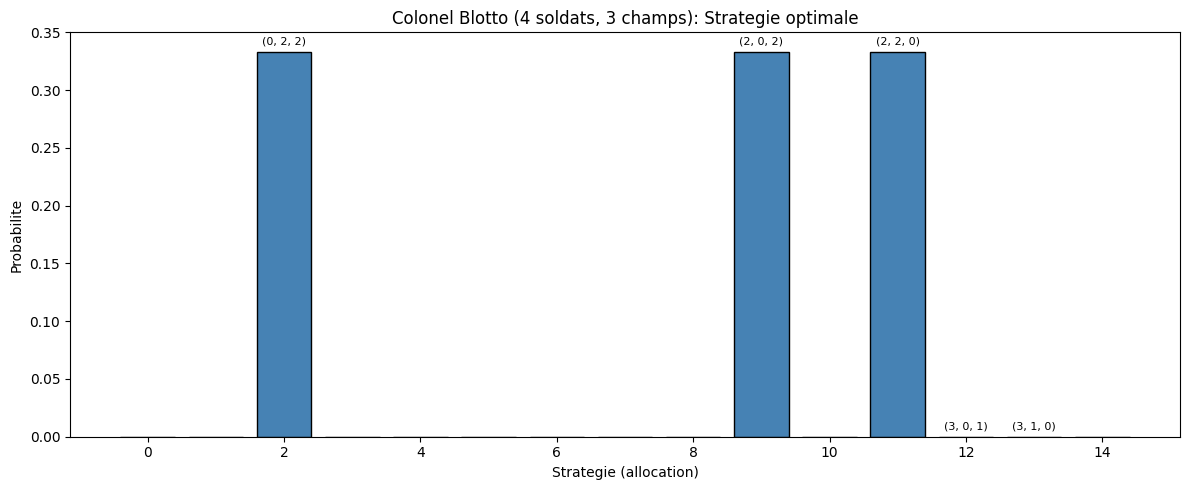

In [11]:
# Visualiser la distribution
fig, ax = plt.subplots(figsize=(12, 5))

strategies = generate_blotto_strategies(4, 3)
x = range(len(strategies))
ax.bar(x, sigma_opt, color='steelblue', edgecolor='black')

# Marquer les strategies principales
top_idx = np.argsort(sigma_opt)[-5:]
for i in top_idx:
    ax.annotate(f"{strategies[i]}", (i, sigma_opt[i]), 
                textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

ax.set_xlabel('Strategie (allocation)')
ax.set_ylabel('Probabilite')
ax.set_title('Colonel Blotto (4 soldats, 3 champs): Strategie optimale')

plt.tight_layout()
plt.show()

## 7. Resume

### Points cles

| Concept | Description |
|---------|-------------|
| **Somme nulle** | $u_1 + u_2 = 0$ pour tout profil |
| **Maximin** | Row maximise son pire cas |
| **Minimax** | Col minimise le meilleur cas de Row |
| **Theoreme minimax** | max min = min max en strategies mixtes |
| **Valeur du jeu** | Gain de Row a l'equilibre |

### Algorithmes

| Methode | Complexite | Description |
|---------|------------|-------------|
| Enumeration | $O(mn)$ | Point-selle en strategies pures |
| LP | Polynomiale | Resolution exacte par simplexe/point interieur |
| Nashpy | Polynomiale | Bibliotheque specialisee |

### Applications

- Jeux de plateau (echecs, go) : evaluation de positions
- Securite : allocation de ressources defensives
- Sport : choix de strategies
- Economie : competition a somme nulle

## 8. Exercices

### Exercice 1
Resolvez le jeu Colonel Blotto avec 5 soldats et 2 champs.

### Exercice 2
Prouvez que la valeur du jeu de Pierre-Feuille-Ciseaux est 0.

### Exercice 3
Trouvez un jeu 3x3 a somme nulle avec un point-selle en strategies pures.

In [12]:
# Espace pour les exercices

---

**Notebook precedent**: [GameTheory-4-NashEquilibrium](GameTheory-4-NashEquilibrium.ipynb)  
**Notebook suivant**: [GameTheory-6-EvolutionTrust](GameTheory-6-EvolutionTrust.ipynb)